In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
data = pd.read_csv('insurance.txt')

Normalization

In [ ]:
def preproc(data, degree):

    y_data = data['charges']
    y_median = y_data.median()
    y_data = y_data/y_data.median()
    x_data = data.drop(['charges','children'], axis = 1)
    poly = PolynomialFeatures(int(degree))
    X = poly.fit_transform(x_data)
    X = np.delete(X, 0, axis = 1)
    X = pd.DataFrame(X)
    X = (X - X.mean())/X.std()
     

    return X , y_data, y_median

In [ ]:
X,y,ymed = preproc(data,5)

Preprocessing

In [ ]:
def split_train_test(X, y, split, seed):
    rows = int(X.shape[0] * split)
    v_rows = int(X.shape[0]*0.9)
    indices = np.array(range(X.shape[0]))
    np.random.seed(seed)
    np.random.shuffle(indices)
    train = indices[:rows]
    valdn = indices[rows:v_rows]
    test = indices[v_rows:]

    X_train, X_test,X_valdn = X.iloc[train].to_numpy(), X.iloc[test].to_numpy(), X.iloc[valdn].to_numpy()
    y_train, y_test,y_valdn = y.iloc[train].to_numpy(), y.iloc[test].to_numpy(), y.iloc[valdn].to_numpy()
    y_train = y_train.reshape((len(train), 1))
    y_test = y_test.reshape((len(test), 1))
    y_valdn = y_valdn.reshape((len(valdn),1))
    return X_train, y_train, X_test, y_test, X_valdn, y_valdn

In [ ]:
X_train, y_train, X_test, y_test, X_valdn, y_valdn = split_train_test(X, y, 0.7, 0)

In [ ]:
def hypothesis(theta, X):
    Z = X @ theta
    return Z

In [ ]:
def loss(Z, y, ymed):
    m = Z.shape[0]
    cost = 1/m * np.sum(np.square((Z - y) * ymed))
    return cost

In [ ]:
def gradient_descent(theta, X, y, learning_rate, iterations):
    losses = []
    Z = hypothesis(theta, X)
    m = X.shape[0]
    for _ in range(iterations):
        theta = theta - (learning_rate * 1/m * (X.T.dot((X.dot(theta)) - y)))
        Z = X @ theta
        losses.append(loss(Z, y, ymed))
    return Z, theta, losses

In [ ]:
def plot_loss(iterations, cost):
    plt.plot(np.array(range(iterations)), cost)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

Main Function

In [ ]:
def surface_plot(X, y, prediction, degree):
  fig = plt.figure(figsize=[40,70])
  ax = fig.add_subplot(5,2,degree, projection='3d')
  ax.scatter(X[:,0], X[:,1], y, zdir='z', s=20, c='#9467bd', depthshade=True)
  Y_plot = np.asarray(prediction)
  X = np.asarray(X)
  ax.plot_trisurf(X[:,0], X[:,1], Y_plot[:,0], cmap = 'viridis')
  ax.set_xlabel('$Age$', fontsize=20, rotation=150)
  ax.set_ylabel('$BMI$', fontsize=20, rotation=150)
  ax.set_zlabel('$Insurance$', fontsize=20, rotation=60)
  ax.set_title('Degree: ' + str(degree), fontsize=30)
  plt.show()


In [ ]:
def main(data, split, seed, learning_rate, iterations):
  min_losses = []
  for degree in range(1, 11):
    X, y, ymed = preproc(data, degree)
    X_train, y_train, X_test, y_test, X_valdn, y_valdn = split_train_test(X, y, split, seed)
    theta = np.random.random((X.shape[1], 1))
    prediction, final_theta, losses = gradient_descent(theta, X_test, y_test, learning_rate, iterations)
    min_losses.append(np.sqrt(losses[-1]))
    # surface_plot(X_train, y_train, prediction, degree)
  return min_losses


In [ ]:
min_losses_gd = main(data, 0.7, 0, 0.01, 1000)

In [ ]:
min_losses_gd

[19499.14542573446,
 19481.1548287375,
 19465.953985981025,
 19429.48347045511,
 19397.548115817077,
 19374.14432085149,
 19356.781666210823,
 19296.69778740208,
 19201.186105691962,
 19127.324394356267]

In [ ]:
class Ridge_Regression():
  def __init__(self, learning_rate, iterations, lambda_R):
    self.learning_rate = learning_rate
    self.iterations = iterations
    self.lambda_R = lambda_R
  
  def fit(self, X, y):
    self.m, self.n = X.shape
    self.theta = np.zeros(self.n).reshape(self.n, 1)
    self.bias = 0
    self.X = X
    self.y = y
    for _ in range(self.iterations):
      self.update_theta()
    return self
  
  def update_theta(self):
    y_predicted = self.predict(self.X)
    der_theta = ( - ( 2 * ( self.X.T ).dot( self.y - y_predicted ) ) +               
               ( 2 * self.lambda_R * self.theta ) ) / self.m 
    der_bias = - 2 * np.sum( self.y - y_predicted ) / self.m

    self.theta = self.theta - self.learning_rate * der_theta     
    self.bias = self.bias - self.learning_rate * der_bias         
    return self
  
  def predict(self, X) :     
        return X.dot(self.theta) + self.bias 

In [ ]:
ridge = Ridge_Regression(learning_rate= 0.01, iterations= 1000, lambda_R= 1)
ridge.fit(X_train, y_train)
y_predicted = ridge.predict( X_test )     
print( "Predicted values ", np.round( y_predicted[:5]) )      
print( "Real values      ", y_test[:5])     
print( "Trained theta        ", np.round( ridge.theta[0] ) )     
print( "Trained bias        ", np.round( ridge.bias ) )
print(y_predicted.shape) 

Predicted values  [[2.]
 [1.]
 [1.]
 [2.]
 [1.]]
Real values       [[2.7829074 ]
 [0.68147314]
 [1.0355795 ]
 [3.0352414 ]
 [4.36379678]]
Trained theta         [0.]
Trained bias         1.0
(134, 1)


In [ ]:
class Lasso_Regression():
  
  def __init__ (self, learning_rate, iterations, lambda_L):
    self.learning_rate = learning_rate
    self.iterations = iterations
    self.lambda_L = lambda_L
  
  def fit(self, X, y):
    self.m, self.n = X.shape
    self.theta = np.zeros(self.n).reshape(self.n, 1)
    self.bias = 0
    self.X = X
    self.y = y
    for _ in range(self.iterations):
      self.update_theta()
    return self
  
  def update_theta(self):
    y_predicted = self.predict(self.X)
    der_theta = np.zeros(self.n).reshape(self.n, 1)
    for j in range(self.n):
      if self.theta[j] > 0:
        der_theta[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.y - y_predicted ) )  
                           + self.lambda_L ) / self.m
      else:
        der_theta[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.y - y_predicted ) )  
                           - self.lambda_L ) / self.m 
    der_bias = - 2 * np.sum( self.y - y_predicted ) / self.m
    self.theta = self.theta - self.learning_rate * der_theta     
    self.bias = self.bias - self.learning_rate * der_bias         
    return self
  
  def predict(self, X) :     
        return X.dot(self.theta) + self.bias 

In [ ]:
lasso = Lasso_Regression(learning_rate= 0.01, iterations= 1000, lambda_L= 500)
lasso.fit(X_train, y_train)
y_predicted = lasso.predict(X_train)     
print( "Predicted values ", np.round( y_predicted[:5]) )      
print( "Real values      ", y_test[:5])     
print( "Trained theta        ", np.round( lasso.theta[0] ) )     
print( "Trained bias        ", np.round( lasso.bias ) ) 
print(y_predicted.shape)

Predicted values  [[2.]
 [1.]
 [2.]
 [2.]
 [1.]]
Real values       [[2.7829074 ]
 [0.68147314]
 [1.0355795 ]
 [3.0352414 ]
 [4.36379678]]
Trained theta         [0.]
Trained bias         1.0
(936, 1)


Main functions for Lasso and Ridge

In [ ]:
def GD_reg(X, y, ymed, iterations, lambda_l, lambda_r, learning_rate):
  m = X.shape[0]
  ridge = Ridge_Regression(learning_rate, iterations, lambda_r)
  ridge.fit(X, y)
  y_predicted_ridge = ridge.predict( X )

  lasso = Lasso_Regression(learning_rate, iterations, lambda_l)   
  lasso.fit(X, y)
  y_predicted_lasso = lasso.predict( X )    

  lasso_cost = 1/m * np.sum(np.square((y - y_predicted_lasso) * ymed))
  ridge_cost = 1/m * np.sum(np.square((y - y_predicted_ridge) * ymed))

  return np.sqrt(lasso_cost), np.sqrt(ridge_cost)


In [ ]:
def main_lasso_ridge(data, split, seed, learning_rate, iterations, lambda_l, lambda_r):
  min_losses_lasso_train = []
  min_losses_ridge_train = []
  min_losses_lasso_test = []
  min_losses_ridge_test = []
  min_losses_lasso_valdn = []
  min_losses_ridge_valdn = []
  for degree in range(1, 11):
    X, y, ymed = preproc(data, degree)
    X_train, y_train, X_test, y_test, X_valdn, y_valdn = split_train_test(X, y, split, seed)
    
    lasso_cost_train, ridge_cost_train = GD_reg(X_train, y_train, ymed, iterations, lambda_l, lambda_r, learning_rate)
    lasso_cost_test, ridge_cost_test = GD_reg(X_test, y_test, ymed, iterations, lambda_l, lambda_r, learning_rate)
    lasso_cost_valdn, ridge_cost_valdn = GD_reg(X_valdn, y_valdn, ymed, iterations, lambda_l, lambda_r, learning_rate)
    
    min_losses_lasso_train.append(lasso_cost_train)
    min_losses_ridge_train.append(ridge_cost_train)
    min_losses_lasso_test.append(lasso_cost_test)
    min_losses_ridge_test.append(ridge_cost_test)
    min_losses_lasso_valdn.append(lasso_cost_valdn)
    min_losses_ridge_valdn.append(ridge_cost_valdn)
  
  return min_losses_lasso_train, min_losses_ridge_train, min_losses_lasso_test, min_losses_ridge_test, min_losses_lasso_valdn, min_losses_ridge_valdn

In [ ]:
min_losses_lasso_train, min_losses_ridge_train, min_losses_lasso_test, min_losses_ridge_test, min_losses_lasso_valdn, min_losses_ridge_valdn = main_lasso_ridge(data, 0.7, 0, 0.01, 1000, 0.05, 1)

In [ ]:
print(min_losses_lasso_train)
print(min_losses_ridge_train)
print(min_losses_lasso_test)
print(min_losses_ridge_test)
print(min_losses_lasso_valdn)
print(min_losses_ridge_valdn)

[11215.637147742811, 11200.409220065052, 11192.314949693582, 11186.055662521792, 11178.706254348677, 11169.117408279377, 11158.441112859913, 11149.07913842301, 11142.457554336192, 11138.462150110388]
[11215.637912266355, 11200.45316678812, 11192.361616153208, 11186.084680662872, 11178.729341911563, 11169.161872019504, 11158.498043785074, 11149.132210866033, 11142.499335351942, 11138.480378438835]
[12789.637244473439, 12790.717292155377, 12788.468448554511, 12786.49389146028, 12775.782593075255, 12737.630782631713, 12658.061665630552, 12540.530433647387, 12408.42535716891, 12287.256513782348]
[12789.678845432662, 12790.973279672076, 12789.012433223468, 12787.079248204942, 12776.999297719138, 12740.806789734497, 12664.881686976501, 12551.649129167017, 12422.136701354035, 12300.927315815341]
[11072.109530126192, 11039.710392985726, 10973.941443078167, 10947.599104242492, 10942.170950982583, 10928.007992391114, 10903.777864626718, 10875.01821360626, 10845.041117358667, 10816.452977562865]


**SGD WITHOUT RIDGE AND LASSO REGRESSION**

In [ ]:
def SGD(x, y, epochs, learning_rate = 0.001):
 
    number_of_features = x.shape[1] 
    
    # Our case number of features = 2 (age, bmi)
    w = np.ones(shape=(1,number_of_features)) 
    b = 0
    total_samples = x.shape[0]
    cost_list = []
    iteration_list = []
    
    for i in range(epochs):    
        index = i % (total_samples)
        sample_x = x[index].reshape(number_of_features,1)
        sample_y = y[index][0]
        
        
        y_predicted = np.dot(w, sample_x) + b
        
        w_der = sample_x.T*(y_predicted-sample_y)
        b_der = (y_predicted-sample_y)
        
        w = (w - learning_rate * w_der)
        b = (b - learning_rate * b_der)
        
        cost = ((sample_y-y_predicted)*ymed)**2
        
        if i%50 == 0: # Every 50th iteration, record the cost and epoch value
            cost_list.append(cost)
            iteration_list.append(i)
            
        
    return w,b,cost_list,iteration_list
#print("Training Error: " + str(np.sqrt((1/X_train.shape[0])*sum(costs))))

In [ ]:
def testing(x,y,w,b) :
  sum =0
  for i in range(x.shape[0]) :
    y_pred = np.dot(w,x[i].T) + b
    cost = ((y_pred-y[i][0])*ymed)**2
    sum += cost
  sum = np.sqrt((1/x.shape[0])*sum)
  return sum[0][0]

**SGD USING RIDGE AND LASSO REGRESSION**

In [ ]:
class Ridge_Regression_SGD():
  def __init__(self, learning_rate, iterations, lambda_R):
    self.m, self.n = X.shape
    self.learning_rate = learning_rate
    self.iterations = iterations
    self.lambda_R = lambda_R
    self.theta = np.zeros(self.n).reshape(self.n, 1)
    self.bias = 0
  
  def fit(self, X, y):
    self.X = X
    self.y = y
    self.update_theta()
    return self
  
  def update_theta(self):
    y_predicted = self.predict(self.X)
    der_theta = -((self.X).dot( self.y - y_predicted ))  +  (self.lambda_R * self.theta )  
    der_bias =  - np.sum( self.y - y_predicted) 

    self.theta = self.theta - self.learning_rate * der_theta     
    self.bias = self.bias - self.learning_rate * der_bias         
    return self
  
  def predict(self, X) :     
        return (X.T).dot(self.theta) + self.bias 

In [ ]:
class Lasso_Regression_SGD():
  
  def __init__ (self, learning_rate, iterations, lambda_L):
    self.learning_rate = learning_rate
    self.iterations = iterations
    self.lambda_L = lambda_L
    self.m, self.n = X.shape
    self.theta = np.zeros(self.n).reshape(self.n, 1)
    self.bias = 0
  
  def fit(self, X, y):
    self.X = X
    self.y = y
    self.update_theta()
    return self
  
  def update_theta(self):
    y_predicted = self.predict(self.X)
    der_theta = np.zeros(self.n).reshape(self.n, 1)
    for j in range(self.n):
      if self.theta[j] > 0:
        der_theta[j] = -((self.X[j]).dot( self.y - y_predicted )) + self.lambda_L 
      else:
         der_theta[j] = -((self.X[j]).dot( self.y - y_predicted )) - self.lambda_L 
    der_bias = - np.sum( self.y - y_predicted ) 
    self.theta = self.theta - self.learning_rate * der_theta     
    self.bias = self.bias - self.learning_rate * der_bias         
    return self
  
  def predict(self, X) :     
        return (X.T).dot(self.theta) + self.bias 

In [ ]:
def SGD_reg(x, y, epochs,lambda_l,lambda_r,learning_rate):
 
    number_of_features = x.shape[1] 
    
    w = np.ones(shape=(1,number_of_features)) 
    b = 0
    total_samples = x.shape[0]
    ridge_cost_list = []
    lasso_cost_list = []
    iteration_list = []
    
    ridge = Ridge_Regression_SGD(learning_rate,1000,lambda_r)
    lasso = Lasso_Regression_SGD(learning_rate,1000,lambda_l)
    
    for i in range(epochs):    
        index = i % (total_samples)
        sample_x = x[index].reshape(number_of_features,1)
        sample_y = y[index][0]
        
        ridge.fit(sample_x,sample_y)
        lasso.fit(sample_x,sample_y)
        y_predicted_ridge = ridge.predict(sample_x)
        y_predicted_lasso = lasso.predict(sample_x)
        
        #y_predicted = np.dot(w, sample_x) + b
        
        #w_der = sample_x.T*(y_predicted-sample_y)
        #b_der = (y_predicted-sample_y)
        
        #w = (w - learning_rate * w_der)
        #b = (b - learning_rate * b_der)
        
        ridge_cost = ((sample_y-y_predicted_ridge)*ymed)**2
        lasso_cost = ((sample_y-y_predicted_lasso)*ymed)**2
        
        if i%50 == 0: # Every 50th iteration, record the cost and epoch value
            ridge_cost_list.append(ridge_cost)
            lasso_cost_list.append(lasso_cost)
            iteration_list.append(i)
    w_r = ridge.theta
    b_r = ridge.bias 
    w_l = lasso.theta
    b_l = lasso.bias     
        
    return w_r,b_r,w_l,b_l,ridge_cost_list,lasso_cost_list,iteration_list

In [ ]:
def testing_reg(x,y,w,b) :
  sum =0
  for i in range(x.shape[0]) :
    y_pred = np.dot(w,x[i].T.reshape(1,x[i].shape[0])) + b
    cost = ((y_pred-y[i][0])*ymed)**2
    sum += cost
  sum = np.sqrt((1/x.shape[0])*sum)
  return sum[0][0]

In [ ]:
lambda_l = 0.01
lambda_r = 0.01
ridge_errors_list = []
lasso_errors_list = []
learning_rate = 0.1
for i in range(100):
  w_r,b_r,w_l,b_l,ridge_cost_list,lasso_cost_list,iteration_list = SGD_reg(X_train,y_train,10000,lambda_l,lambda_r,0.001)
  ridge_errors_list.append(testing_reg(X_valdn,y_valdn,w_r,b_r))
  lasso_errors_list.append(testing_reg(X_valdn,y_valdn,w_l,b_l))
  lambda_l += 0.01
  lambda_r += 0.01

#ridge_errors_list, lasso_errors_list
np.min(lasso_errors_list)

11464.39003606704

In [ ]:
learn_rate = 0.01
ridge_errors_list = []
lasso_errors_list = []
for i in range(7):
  w_r,b_r,w_l,b_l,ridge_cost_list,lasso_cost_list,iteration_list = SGD_reg(X_train,y_train,10000,0.06,0.17,learn_rate)
  ridge_errors_list.append(testing_reg(X_valdn,y_valdn,w_r,b_r))
  lasso_errors_list.append(testing_reg(X_valdn,y_valdn,w_l,b_l))
  learn_rate /= 10
  #print(w_r)
#ridge_errors_list, lasso_errors_list
np.min(lasso_errors_list)

11374.042891340468

**VALIDATION RESULTS : LAMBDA_L = 0.06 ; LAMBDA_R = 0.17; LEARNING RATE =0.001**

**TESTING FOR EACH DEGREE WITHOUT REGULARIZATION**

In [ ]:
errors_list = []
for i in range(1,11) : 
  X, y, ymed = preproc(data, i)
  X_train, y_train, X_test, y_test,X_valdn,y_valdn = split_train_test(X, y, 0.7, 0) 
  w,b,cost_list,iteration_list = SGD(X_train,y_train,10000,0.001)
  errors_list.append(testing(X_train,y_train,w,b))
errors_list

[11216.13735121861,
 11210.21729603997,
 11224.5195579966,
 11237.349294605665,
 11239.582914445395,
 11237.913429555067,
 11235.638344623205,
 11234.059643729077,
 11235.193189374455,
 11244.577490888316]

**TESTING FOR EACH DEGREE WITH REGULARIZATION**

In [ ]:
ridge_errors_list = []
lasso_errors_list = []
for i in range(1,11) : 
  X, y, ymed = preproc(data, i)
  X_train, y_train, X_test, y_test,X_valdn,y_valdn = split_train_test(X, y, 0.7, 0) 
  w_r,b_r,w_l,b_l,ridge_cost_list,lasso_cost_list,iteration_list = SGD_reg(X_train,y_train,10000,0.06,0.17,0.001)
  ridge_errors_list.append(testing_reg(X_test,y_test,w_r,b_r))
  lasso_errors_list.append(testing_reg(X_test,y_test,w_l,b_l))
ridge_errors_list

[13201.170382136122,
 13535.52670379489,
 13642.535433490195,
 13647.458398258626,
 13631.633795156233,
 13624.566512348125,
 13626.154479979947,
 13630.587611489418,
 13634.329580235135,
 13636.304928410102]

Surface Plots

In [ ]:
prediction, final_theta, losses = gradient_descent(theta, X_train, y_train, 0.01, 1000)

NameError: ignored

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

NameError: ignored

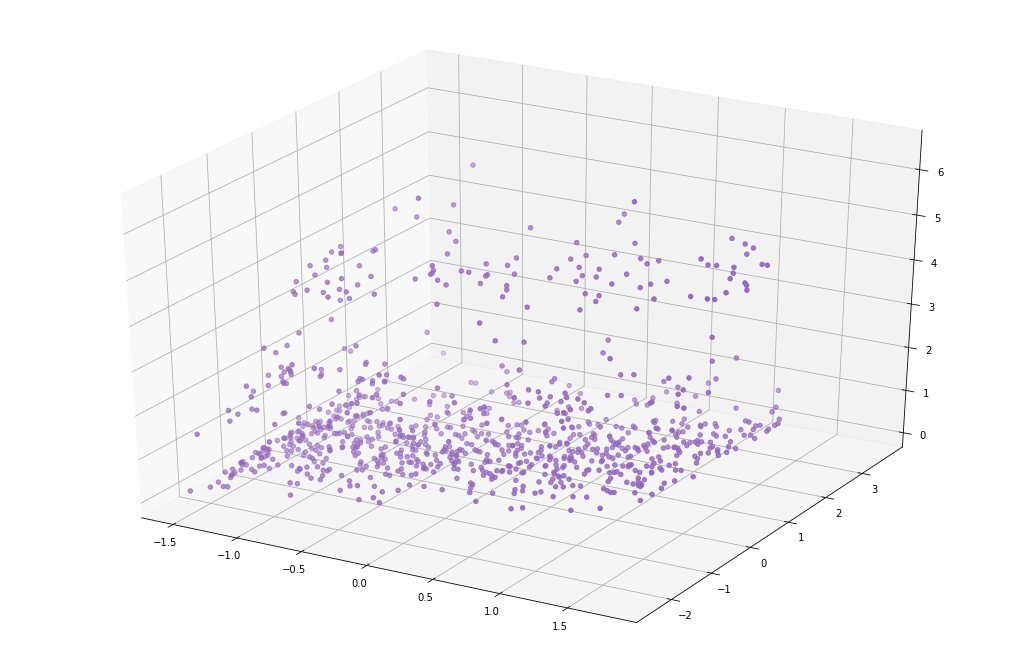

In [ ]:
fig = plt.figure(figsize=[40,70])
ax = fig.add_subplot(5,2,1, projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train, zdir='z', s=20, c='#9467bd', depthshade=True)
Y_plot = np.asarray(prediction)
X_train = np.asarray(X_train)
ax.plot_trisurf(X_train[:,0], X_train[:,1], Y_plot[:,0], cmap = 'viridis')
plt.show()